<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_2_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 4 Material

* Part 4.1: Encoding a Feature Vector for PyTorch Deep Learning [[Video]](https://www.youtube.com/watch?v=Vxz-gfs9nMQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_1_feature_encode.ipynb)
* **Part 4.2: PyTorch Multiclass Classification for Deep Neural Networks with ROC and AUC** [[Video]](https://www.youtube.com/watch?v=-f3bg9dLMks&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_2_multi_class.ipynb)
* Part 4.3: PyTorch Regression for Deep Neural Networks with RMSE [[Video]](https://www.youtube.com/watch?v=wNhBUC6X5-E&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_3_regression.ipynb)
* Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training [[Video]](https://www.youtube.com/watch?v=VbDg8aBgpck&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_4_backprop.ipynb)
* Part 4.5: Neural Network RMSE and Log Loss Error Calculation from Scratch [[Video]](https://www.youtube.com/watch?v=wmQX1t2PHJc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/pytorch/t81_558_class_04_5_rmse_logloss.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running and maps Google Drive if needed. We also initialize the PyTorch device to either GPU (if available) or CPU.

In [1]:
import torch
import io
import copy

try:
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Early stopping (see Module 3.4)
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""
    
  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

    
# Make use of a GPU if one is available. (see Module 3.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


# Part 4.2: Multiclass Classification with ROC and AUC

The output of modern neural networks can be of many different forms. However, classically, neural network output has typically been one of the following:

* **Binary Classification** - Classification between two possibilities (positive and negative). Common in medical testing, does the person has the disease (positive) or not (negative).
* **Classification** - Classification between more than 2.  The iris dataset (3-way classification).
* **Regression** - Numeric prediction.  How many MPG does a car get? (covered in next video)

We will look at some visualizations for all three in this section.

It is important to evaluate the false positives and negatives in the results produced by a neural network. We will now look at assessing error for both classification and regression neural networks.

## Binary Classification and ROC Charts

Binary classification occurs when a neural network must choose between two options: true/false, yes/no, correct/incorrect, or buy/sell. To see how to use binary classification, we will consider a classification system for a credit card company. This system will either "issue a credit card" or "decline a credit card." This classification system must decide how to respond to a new potential customer.  

When you have only two classes that you can consider, the objective function's score is the number of false-positive predictions versus the number of false negatives. False negatives and false positives are both types of errors, and it is essential to understand the difference. For the previous example, issuing a credit card would be positive. A false positive occurs when a model decides to issue a credit card to someone who will not make payments as agreed. A false negative happens when a model denies a credit card to someone who would have made payments as agreed.  

Because only two options exist, we can choose the mistake that is the more serious type of error, a false positive or a false negative. For most banks issuing credit cards, a false positive is worse than a false negative. Declining a potentially good credit card holder is better than accepting a credit card holder who would cause the bank to undertake expensive collection activities.

Consider the following program that uses the [wcbreast_wdbc dataset](https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv) to classify if a breast tumor is cancerous (malignant) or not (benign).  

In [2]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA','?'])

pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)

display(df)

,id,diagnosis,...,worst_symmetry,worst_fractal_dimension
0,842302,M,...,0.4601,0.11890
1,842517,M,...,0.2750,0.08902
...,...,...,...,...,...
567,927241,M,...,0.4087,0.12400
568,92751,B,...,0.2871,0.07039


ROC curves can be a bit confusing. However, they are prevalent in analytics. It is essential to know how to read them. Even their name is confusing. Do not worry about their name; the receiver operating characteristic curve (ROC) comes from electrical engineering (EE).

Binary classification is common in medical testing. Often you want to diagnose if someone has a disease. This diagnosis can lead to two types of errors, known as false positives and false negatives:

* **False Positive** - Your test (neural network) indicated that the patient had the disease; however, the patient did not.
* **False Negative** - Your test (neural network) indicated that the patient did not have the disease; however, the patient did have the disease.
* **True Positive** - Your test (neural network) correctly identified that the patient had the disease.
* **True Negative** - Your test (neural network) correctly identified that the patient did not have the disease.

Figure 4.ETYP shows you these types of errors.

**Figure 4.ETYP: Type of Error**
![Type of Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_errors.png "Type of Error")

Neural networks classify in terms of the probability of it being positive. However, at what possibility do you give a positive result? Is the cutoff 50%? 90%? Where you set, this cutoff is called the threshold. Anything above the cutoff is positive; anything below is negative. 

The specificity of a model is its ability to designate a sample that is actually negative as negative. 

* A highly specific model has few false positive results. 
* A highly sensitive model has few false negative results.

Setting this cutoff allows the model to be more sensitive or specific:


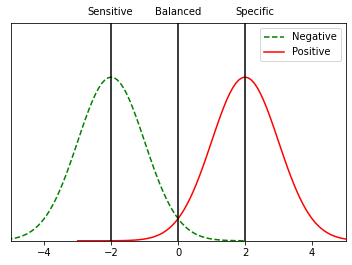

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu1 = -2
mu2 = 2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 5*sigma, mu1 + 4*sigma, 100)
x2 = np.linspace(mu2 - 5*sigma, mu2 + 4*sigma, 100)
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma)/1,color="green", 
         linestyle='dashed')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma)/1,color="red")
plt.axvline(x=-2,color="black")
plt.axvline(x=0,color="black")
plt.axvline(x=+2,color="black")
plt.text(-2.7,0.55,"Sensitive")
plt.text(-0.7,0.55,"Balanced")
plt.text(1.7,0.55,"Specific")
plt.ylim([0,0.53])
plt.xlim([-5,5])
plt.legend(['Negative','Positive'])
plt.yticks([])
plt.show()

We will now train a neural network for the Wisconsin breast cancer dataset. We begin by preprocessing the data. Because we have all numeric data, we compute a z-score for each column.

In [4]:
from scipy.stats import zscore

x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

# Convert to numpy - Regression
x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}).values # Binary classification, 
                                              # M is 1 and B is 0

We can now define two functions. The first function plots a confusion matrix. The second function plots a ROC chart.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### ROC Chart Example

The following code demonstrates how to implement a ROC chart in Python.

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).float().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],1).to(device)

loss_fn = nn.BCELoss()# Binary Cross Entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)
  model.train()
  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device))
    loss = loss_fn(y_batch_pred, y_batch.reshape(-1,1).to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item(), (i + 1)* len(x_batch)
    if i == len(steps)-1:
      model.eval()
      pred = model(x_test)
      vloss = loss_fn(pred, y_test.reshape(-1,1))
      if es(model,vloss): done = True
      pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 0.04413526505231857, vloss: 0.067089, EStop:[0/5]: 100%|██████████| 27/27 [00:00<00:00, 66.32it/s]
Epoch: 2, tloss: 0.005124636460095644, vloss: 0.067487, EStop:[1/5]: 100%|██████████| 27/27 [00:00<00:00, 83.18it/s]
Epoch: 3, tloss: 0.005163597408682108, vloss: 0.056962, EStop:[0/5]: 100%|██████████| 27/27 [00:00<00:00, 135.11it/s]
Epoch: 4, tloss: 0.004068071488291025, vloss: 0.061940, EStop:[1/5]: 100%|██████████| 27/27 [00:00<00:00, 110.09it/s]
Epoch: 5, tloss: 0.1279412806034088, vloss: 0.076508, EStop:[2/5]: 100%|██████████| 27/27 [00:00<00:00, 111.20it/s]
Epoch: 6, tloss: 0.0014331989223137498, vloss: 0.116431, EStop:[3/5]: 100%|██████████| 27/27 [00:00<00:00, 159.88it/s]
Epoch: 7, tloss: 0.057050250470638275, vloss: 0.084794, EStop:[4/5]: 100%|██████████| 27/27 [00:00<00:00, 120.87it/s]
Epoch: 8, tloss: 0.04849902167916298, vloss: 0.088212, EStop:[Stopped on 5]: 100%|██████████| 27/27 [00:00<00:00, 114.34it/s]


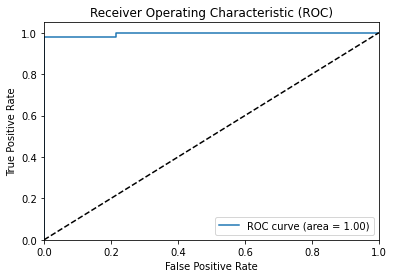

In [8]:
pred = model(x_test)
plot_roc(pred.detach(),y_test)

### Multiclass Classification Error Metrics

If you want to predict more than one outcome, you will need more than one output neuron. Because a single neuron can predict two results, a neural network with two output neurons is somewhat rare. If there are three or more outcomes, there will be three or more output neurons. The following sections will examine several metrics for evaluating classification error. We will assess the following classification neural network.

In [9]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['product'])
products = le.classes_

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.softmax(self.fc3(x))

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).long()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).long().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],len(products)).to(device)

loss_fn = nn.CrossEntropyLoss()# cross entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)
  model.train()
  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device))
    loss = loss_fn(y_batch_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item(), (i + 1)* len(x_batch)
    if i == len(steps)-1:
      model.eval()
      pred = model(x_test)
      vloss = loss_fn(pred, y_test)
      if es(model,vloss): done = True
      pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 1.3321670293807983, vloss: 1.667043, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 109.80it/s]
Epoch: 2, tloss: 1.8370195627212524, vloss: 1.631700, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 115.01it/s]
Epoch: 3, tloss: 1.815244197845459, vloss: 1.659445, EStop:[1/5]: 100%|██████████| 94/94 [00:00<00:00, 115.84it/s]
Epoch: 4, tloss: 1.582081913948059, vloss: 1.645450, EStop:[2/5]: 100%|██████████| 94/94 [00:00<00:00, 99.13it/s] 
Epoch: 5, tloss: 1.74876070022583, vloss: 1.645588, EStop:[3/5]: 100%|██████████| 94/94 [00:00<00:00, 129.61it/s]
Epoch: 6, tloss: 1.7487555742263794, vloss: 1.663923, EStop:[4/5]: 100%|██████████| 94/94 [00:01<00:00, 83.49it/s]
Epoch: 7, tloss: 1.5012630224227905, vloss: 1.686343, EStop:[Stopped on 5]: 100%|██████████| 94/94 [00:00<00:00, 102.62it/s]


### Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$$ accuracy = \frac{c}{N} $$

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual iris predicted with **argmax**.

In [11]:
pred = model(x_test)
_, predict_classes = torch.max(pred, 1)

Now that we have the actual iris flower predicted, we can calculate the percent accuracy (how many were correctly classified).

In [12]:
from sklearn import metrics

score = metrics.accuracy_score(y_test, predict_classes)
print("Accuracy score: {}".format(score))

Accuracy score: 0.536


### Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:


In [13]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred.detach())
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
_, predict_classes = torch.max(pred, 1)

Numpy array of predictions


tensor([[8.0920e-03, 9.8532e-01, 6.5749e-03, 1.5626e-06, 9.4228e-07, 7.7744e-06,
         5.7717e-07],
        [4.1324e-03, 9.9587e-01, 1.6973e-09, 3.6315e-15, 7.9771e-17, 5.0320e-13,
         3.2115e-17],
        [3.8791e-05, 9.9996e-01, 3.5574e-09, 3.5040e-15, 2.0979e-16, 5.3492e-13,
         8.0280e-17],
        [6.2412e-04, 9.9936e-01, 2.0671e-05, 5.6413e-10, 1.7623e-10, 1.3681e-08,
         8.7071e-11],
        [5.2800e-03, 9.8762e-01, 7.0913e-03, 1.5375e-06, 8.6267e-07, 6.4562e-06,
         5.2099e-07]], grad_fn=<SliceBackward0>)

As percent probability
tensor([8.0920e-01, 9.8532e+01, 6.5749e-01, 1.5626e-04, 9.4228e-05, 7.7744e-04,
        5.7717e-05], grad_fn=<MulBackward0>)
Log loss score: 6.011128479880068


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$$ \mbox{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $$


You should use this equation only as an objective function for classifications that have two outcomes. The variable y-hat is the neural network’s prediction, and the variable y is the known correct answer.  In this case, y will always be 0 or 1.  The training data have no probabilities. The neural network classifies it either into one class (1) or the other (0).  

The variable N represents the number of elements in the training set the number of questions in the test.  We divide by N because this process is customary for an average.  We also begin the equation with a negative because the log function is always negative over the domain 0 to 1.  This negation allows a positive score for the training to minimize.

You will notice two terms are separated by the addition (+).  Each contains a log function.  Because y will be either 0 or 1, then one of these two terms will cancel out to 0.  If y is 0, then the first term will reduce to 0.  If y is 1, then the second term will be 0.  

If your prediction for the first class of a two-class prediction is y-hat, then your prediction for the second class is 1 minus y-hat.  Essentially, if your prediction for class A is 70% (0.7), then your prediction for class B is 30% (0.3).  Your score will increase by the log of your prediction for the correct class.  If the neural network had predicted 1.0 for class A, and the correct answer was A, your score would increase by log (1), which is 0. For log loss, we seek a low score, so a correct answer results in 0.  Some of these log values for a neural network's probability estimate for the correct class:

* -log(1.0) = 0
* -log(0.95) = 0.02
* -log(0.9) = 0.05
* -log(0.8) = 0.1
* -log(0.5) = 0.3
* -log(0.1) = 1
* -log(0.01) = 2
* -log(1.0e-12) = 12
* -log(0.0) = negative infinity

As you can see, giving a low confidence to the correct answer affects the score the most.  Because log (0) is negative infinity, we typically impose a minimum value.  Of course, the above log values are for a single training set element.  We will average the log values for the entire training set.

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

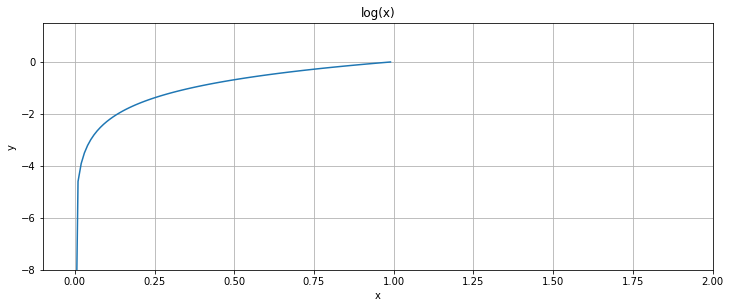

In [14]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(1e-6, 1.0, 1e-2)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

### Confusion Matrix

A confusion matrix shows which predicted classes are often confused for the other classes. The vertical axis (y) represents the true labels and the horizontal axis (x) represents the predicted labels. When the true label and predicted label are the same, the highest values occur down the diagonal extending from the upper left to the lower right. The other values, outside the diagonal, represent incorrect predictions. For example, in the confusion matrix below, the value in row 2, column 1 shows how often the predicted value A occurred when it should have been B.

Normalized confusion matrix
[[0.59 0.41 0.   0.   0.   0.   0.  ]
 [0.03 0.93 0.04 0.   0.   0.   0.  ]
 [0.01 0.87 0.12 0.   0.   0.   0.  ]
 [0.   0.93 0.07 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.47 0.53 0.   0.   0.   0.   0.  ]
 [0.67 0.33 0.   0.   0.   0.   0.  ]]


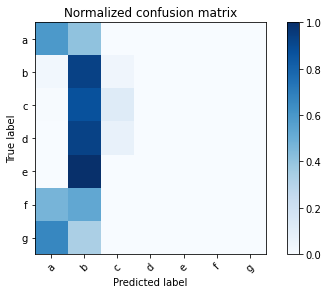

In [15]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, predict_classes)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, 
        title='Normalized confusion matrix')

plt.show()